In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import norm
from scipy import stats

import xgboost as xgb
from sklearn.model_selection import train_test_split

In [49]:
train = pd.read_csv("../../../mltestdata/03_predict_hourly_wage/Income_training.csv")
test = pd.read_csv("../../../mltestdata/03_predict_hourly_wage/Income_testing.csv")

# Data Exploring

In [51]:
train.head()

,compositeHourlyWages,age,yearsEducation,sex1M0F
0,21.38,58,10,1
1,25.15,42,16,1
2,8.57,31,12,0
3,12.07,43,13,0
4,10.97,46,12,0


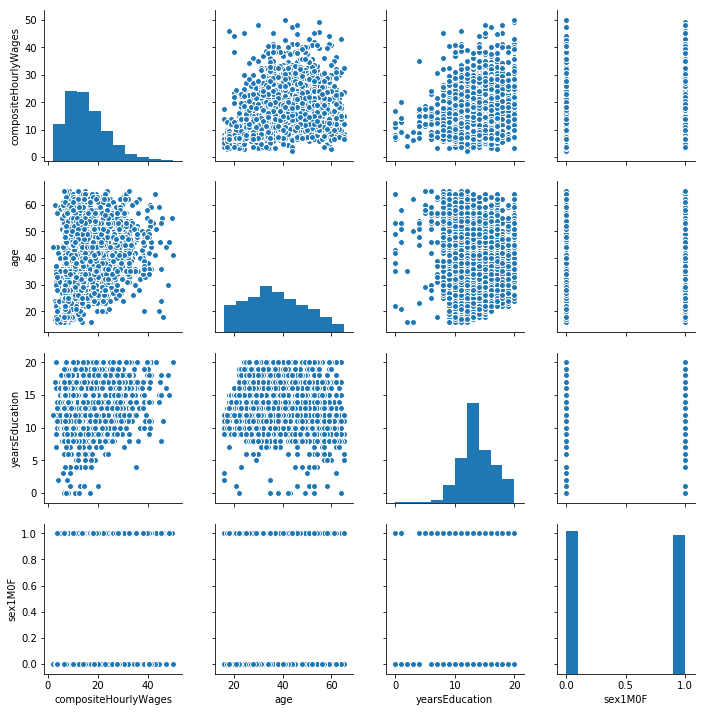

In [50]:
sns.pairplot(train)

In [27]:
train.describe(percentiles=[.20,.40,.60,.80])

,compositeHourlyWages,age,yearsEducation,sex1M0F
count,3197.000000,3197.000000,3197.000000,3197.000000
mean,15.495127,36.884579,13.180794,0.491711
std,7.754763,11.996980,3.042127,0.500009
min,2.300000,16.000000,0.000000,0.000000
20%,8.320000,25.000000,11.000000,0.000000
40%,12.100000,33.000000,12.000000,0.000000
50%,14.210000,36.000000,13.000000,0.000000
60%,16.146000,39.000000,14.000000,1.000000
80%,21.568000,48.000000,16.000000,1.000000
max,49.920000,65.000000,20.000000,1.000000


In [28]:
# pivot
# それぞれ四分位に分けてみて関連を見てみる。
# Mapping features

tdf = train.copy()

tdf.loc[ tdf['compositeHourlyWages'] <= 8.32, 'compositeHourlyWages']                           = 0
tdf.loc[(tdf['compositeHourlyWages'] > 8.32) & (tdf['compositeHourlyWages'] <= 12.1), 'compositeHourlyWages']  = 1
tdf.loc[(tdf['compositeHourlyWages'] > 12.1) & (tdf['compositeHourlyWages'] <= 14.21), 'compositeHourlyWages'] = 2
tdf.loc[(tdf['compositeHourlyWages'] > 14.21) & (tdf['compositeHourlyWages'] <= 16.146), 'compositeHourlyWages'] = 3
tdf.loc[ tdf['compositeHourlyWages'] > 16.146, 'compositeHourlyWages']                           = 4
tdf['compositeHourlyWages'] = tdf['compositeHourlyWages'].astype(int)

#tdf.head()

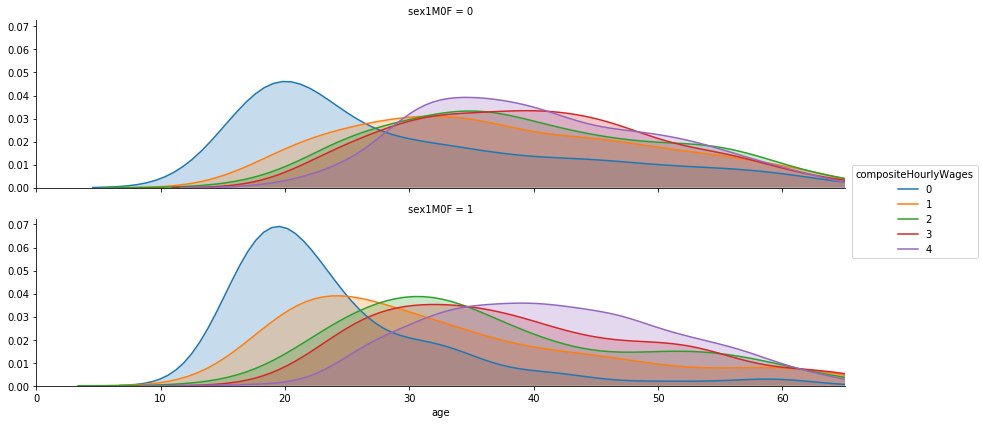

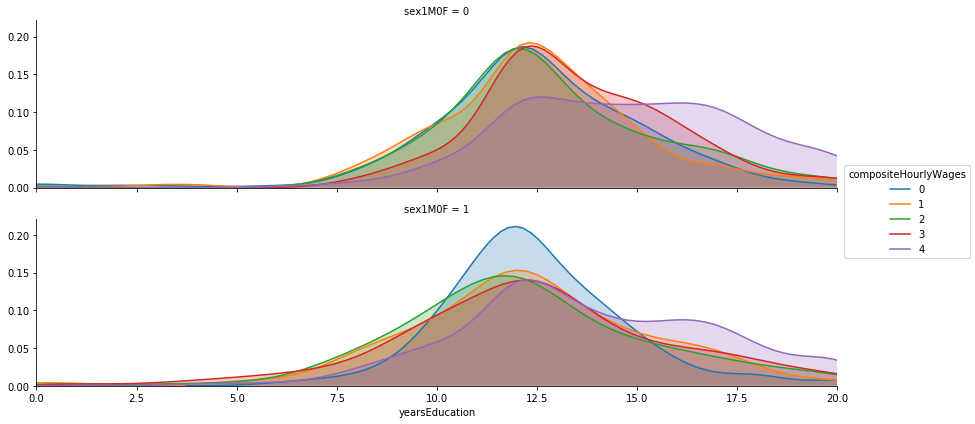

In [29]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

plot_distribution( tdf , var = 'age' , target = 'compositeHourlyWages' , row = 'sex1M0F' )
plot_distribution( tdf , var = 'yearsEducation' , target = 'compositeHourlyWages' , row = 'sex1M0F' )

# Preprocessiong
* * * *

In [30]:
train.describe(percentiles=[.20,.40,.60,.80])

,compositeHourlyWages,age,yearsEducation,sex1M0F
count,3197.000000,3197.000000,3197.000000,3197.000000
mean,15.495127,36.884579,13.180794,0.491711
std,7.754763,11.996980,3.042127,0.500009
min,2.300000,16.000000,0.000000,0.000000
20%,8.320000,25.000000,11.000000,0.000000
40%,12.100000,33.000000,12.000000,0.000000
50%,14.210000,36.000000,13.000000,0.000000
60%,16.146000,39.000000,14.000000,1.000000
80%,21.568000,48.000000,16.000000,1.000000
max,49.920000,65.000000,20.000000,1.000000


In [31]:
train.loc[ train['age'] <= 25, 'age']                           = 0
train.loc[(train['age'] > 25) & (train['age'] <= 33), 'age']  = 1
train.loc[(train['age'] > 33) & (train['age'] <= 36), 'age'] = 2
train.loc[(train['age'] > 36) & (train['age'] <= 39), 'age'] = 3
train.loc[(train['age'] > 39) & (train['age'] <= 48), 'age'] = 4
train.loc[ train['age'] > 48, 'age']                           = 5
train['age'] = train['age'].astype(int)


* * *

In [32]:
train_target = train.compositeHourlyWages.values

test_ID = test['ID']
test.drop("ID", axis = 1, inplace = True)

train.drop(['compositeHourlyWages'], axis=1, inplace=True)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(train,train_target,test_size=0.2,random_state=0)

# Modeling
* * * * *

## XGBoost

### 1. Validation with local train

In [34]:
# xgboostモデルの作成
#ind_params = {'objective': 'reg:linear'}

#reg = xgb.XGBRegressor(**ind_params)
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [35]:
y_train_predict = reg.predict(X_train)
y_pred = reg.predict(X_test)

In [36]:
# The error metric: RMSE
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("RMSE from local train: ", rmse(y_test, y_pred))
print("MSE from local train: ", mean_squared_error(y_test, y_pred))
print("R2 from local train: ", r2_score(y_test, y_pred))

RMSE from local train:  6.0753406574
MSE from local train:  36.9097641035
R2 from local train:  0.385036708425


### 2. Validation with GridSearch

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
# XGBoost params
xgb_params = {
    'objective' : ['reg:gamma','reg:linear'],
    'learning_rate' : [0.05,0.1],
    'n_estimators' : [50,100,200],
    'max_depth' : [2,4,6],
    'subsample' : [0.8,0.85,0.9,0.95],
    'colsample_bytree' : [0.5,1.0],
    'min_child_weight' : [5,10,15]
}

In [39]:
#scoring_func = make_scorer(mean_squared_error)

#grid = GridSearchCV(reg,xgb_params,scoring=scoring_func,cv=5,n_jobs=-1)
grid = GridSearchCV(reg,xgb_params,scoring='neg_mean_squared_error',cv=5,n_jobs=-1)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'objective': ['reg:gamma', 'reg:linear'], 'learning_rate': [0.05, 0.1], 'n_estimators': [50, 100, 200], 'max_depth': [2, 4, 6], 'subsample': [0.8, 0.85, 0.9, 0.95], 'colsample_bytree': [0.5, 1.0], 'min_child_weight': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [40]:
# Best Params and Score
print("Best params: ", grid.best_params_)
print("Best Estimator: ", grid.best_estimator_)

print("MSE: ", grid.best_score_)

# best_score_ : Mean cross-validated score of the best_estimator

Best params:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 100, 'objective': 'reg:gamma', 'subsample': 0.8}
Best Estimator:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:gamma', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
MSE:  -39.9726537988


In [41]:
# The result of combination
index = 1
for params, mean_score, scores in grid.grid_scores_:
    print("%d) %0.3f (+/-%0.03f) " % (index, mean_score, scores.std() / 2))
    print("Params: %r" % params)
    print("_"*30)
    index = index + 1

/Users/suzukiry/lab/March/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


1) -182.567 (+/-4.811) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.8}
______________________________
2) -182.572 (+/-4.810) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.85}
______________________________
3) -182.573 (+/-4.812) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.9}
______________________________
4) -182.582 (+/-4.813) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.95}
______________________________
5) -45.573 (+/-1.920) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50,

In [42]:
# 改めて最適パラメータで学習
gdm = xgb.XGBRegressor(**grid.best_params_)
#gdm = xgb.XGBRegressor(**xgb_params) 
gdm.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:gamma', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [43]:
y_pred_gs = gdm.predict(X_test)

In [45]:
# The error metric: RMSE
print("RMSE from local train: ", rmse(y_test, y_pred_gs))
print("MSE from local train: ", mean_squared_error(y_test, y_pred_gs))
print("R2 from local train: ", r2_score(y_test, y_pred_gs))

RMSE from local train:  6.02660712768
MSE from local train:  36.3199934714
R2 from local train:  0.394863032109


In [46]:
predictions_gdm = gdm.predict(test)

__Findings__
- RMSEがやや下がっている。
- R2がやや増えている。過学習までには至っていないと判断。

# Submission

In [47]:
sub = pd.DataFrame()
sub['ID'] = test_ID
sub['compositeHourlyWages'] = predictions_gdm
sub.to_csv('rs_hourly_submission_28Dec17_rs_predict_hourly_wage_v05_xgb-feature_engineering.csv',index=False)

* * * *

Public LB: 7.93027